In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3097759 sha256=7b32d39d8c58e6032faefccb573a82038c3a5004a30c20e0fde15fb61d2f5b47
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [18]:
import numpy as np
import pandas as pd
from surprise import SVD
from surprise import SVDpp
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import networkx as nx

# Model

In [14]:
data = Dataset.load_builtin('ml-100k')

trainset, testset = train_test_split(data, test_size=0.25)
SVDmodel = SVDpp(n_factors=20, n_epochs=20)
SVDmodel.fit(trainset)
predictions = SVDmodel.test(testset)
rmse = accuracy.rmse(predictions)
user_em = SVDmodel.pu
item_em = SVDmodel.qi

RMSE: 0.9222


In [40]:
print('users ', trainset.n_users)
print('items ', trainset.n_items)
print('ratings ', trainset.n_ratings)

users  943
items  1635
ratings  75000


In [42]:
def get_random_rows(arr, n):
    num_rows = arr.shape[0]
    random_indices = np.random.choice(num_rows, size=n, replace=False)
    random_rows = arr[random_indices, :]
    return random_rows

In [97]:
print(np.amax(user_em))
print(np.amin(user_em))

-0.9741975893011738

In [98]:
user_em[0, :]

array([-0.1179774 ,  0.1201233 , -0.06998179,  0.13295036,  0.02654663,
        0.12404549, -0.05066087,  0.14989959,  0.09377131, -0.09054687,
       -0.20300111, -0.12053706,  0.0543811 , -0.20850387,  0.09136663,
       -0.122687  , -0.04297388,  0.1230497 ,  0.13857018,  0.16607551])

# Distance Metrics

Pairwise Distance Metrics
- Cosine Similarity
- Euclidean Distance
- Pearson Correlation [(=cosine similarity between centered vectors)](https://stats.stackexchange.com/questions/235673/is-there-any-relationship-among-cosine-similarity-pearson-correlation-and-z-sc)
  - assumes linear correlation between two users
- Chebyshev Distance
  - the greatest of their differences




In [211]:
def graph_by_similarity(arr, sim, threshold, title):
    similarity_matrix = sim(arr)

    # Create a graph. Each node represents a data point.
    G = nx.Graph()
    num_data_points = len(arr)
    G.add_nodes_from(range(num_data_points))

    # Add an edge between two data points whose similarity is > threshold.
    for row in range(num_data_points):
        for col in range(row + 1, num_data_points):
            if similarity_matrix[row][col] > threshold:
                G.add_edge(row, col)

    # Remove nodes that don't have any edges (i.e., dissimilar data points).
    G.remove_nodes_from(list(nx.isolates(G)))
    nx.draw(G, with_labels=True)
    plt.title(title)
    plt.show()

    return G

In [142]:
# def weighted_graph_by_similarity(arr, sim):
#     similarity_matrix = sim(arr)

#     # Create a graph. Each node represents a data point.
#     G = nx.Graph()
#     num_data_points = len(arr)
#     G.add_nodes_from(range(num_data_points))

#     # Add an edge between two data points whose similarity is > threshold.
#     for row in range(num_data_points):
#         for col in range(row + 1, num_data_points):
#                 G.add_edge(row, col, weight=similarity_matrix[row][col])

#     G.remove_nodes_from(list(nx.isolates(G)))
#     pos = nx.spring_layout(G)  # Adjust the layout algorithm if needed
#     nx.draw(G, pos, with_labels=True)
#     edge_labels = nx.get_edge_attributes(G, 'weight')
#     nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
#     plt.show()

#     return G

In [215]:
def knn_graph(arr, k, title):
    knn = NearestNeighbors(n_neighbors=k+1)
    knn.fit(arr)
    distances, indices = knn.kneighbors(arr)

    # Create a graph. Each node represents a data point.
    G = nx.Graph()
    num_data_points = len(arr)
    G.add_nodes_from(range(num_data_points))

    # Add edges between each data point and its k nearest neighbors
    for i in range(num_data_points):
        neighbors = indices[i, 1:k+1]
        for neighbor in neighbors:
            G.add_edge(i, neighbor)

    nx.draw(G, with_labels=True)
    plt.title(title)
    plt.show()

In [20]:
def pearson_similarity(a, b):
    mean_a = np.mean(a)
    mean_b = np.mean(b)
    std_a = np.std(a)
    std_b = np.std(b)
    covariance = np.mean((a - mean_a) * (b - mean_b))
    correlation = covariance / (std_a * std_b)
    return correlation

# Graphs

In [194]:
# sample graph
n = 100
user_em = get_random_rows(SVDmodel.pu, n)

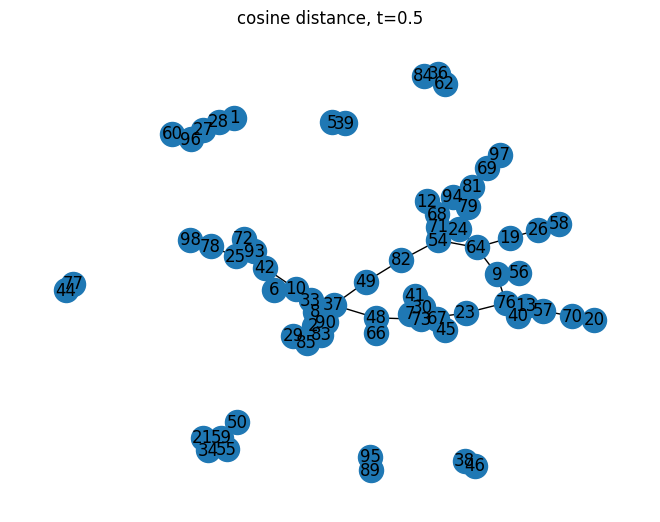

In [212]:
G = graph_by_similarity(user_em, cosine_similarity, 0.5, 'cosine distance, t=0.5')

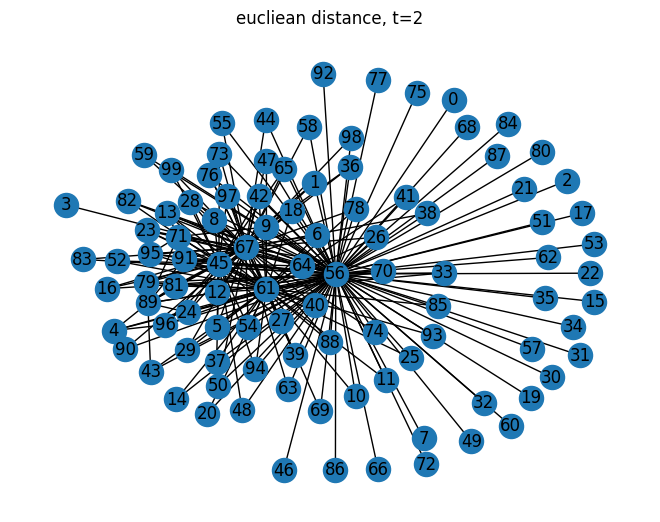

In [213]:
# how to determine what the threshold should be?
G = graph_by_similarity(user_em, euclidean_distances, 2, 'eucliean distance, t=2')

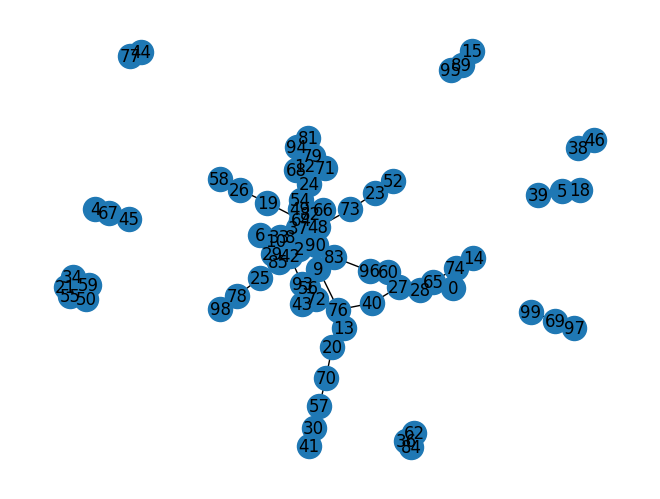

In [220]:
graph_by_similarity(user_em, lambda arr: pairwise_distances(arr, metric=pearson_similarity), 0.5, '')

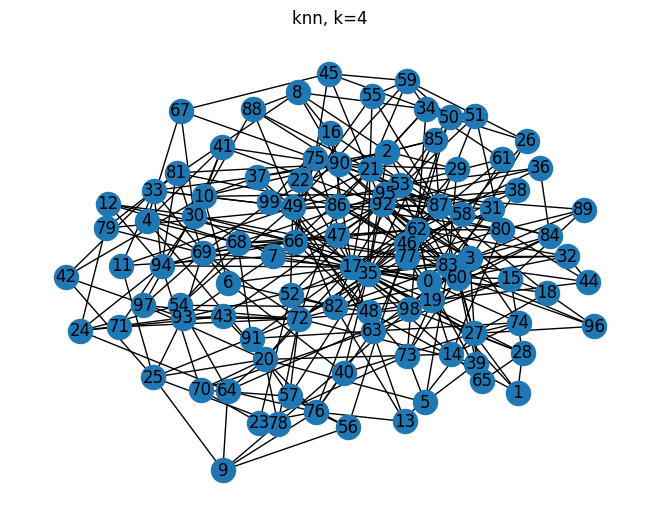

In [216]:
knn_graph(user_em, 4, 'knn, k=4')

# Save Graph

In [148]:
import networkx as nx
import csv

In [160]:
def save_graph_to_csv(graph, csv_file):
    with open(csv_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Source', 'Target'])  # Write the header row

        for edge in graph.edges():
            writer.writerow(edge)  # Write each edge as a row in the CSV file

In [149]:
# def save_weighted_graph_to_csv(graph, csv_file):
#     with open(csv_file, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Source', 'Target', 'Weight'])  # Write the header row

#         for edge in graph.edges(data=True):
#             source, target, data = edge
#             writer.writerow([source, target, data['weight']])  # Write each edge with its weight as a row in the CSV file

In [192]:
save_graph_to_csv(G, 'ed_graph.csv')

In [170]:
nx.write_gexf(G, "graph.gexf")

# Keppler Mapper

In [2]:
!pip install -q kmapper
!pip install -q geopandas
!pip install -q python-igraph plotly ipywidgets

In [3]:
import kmapper as km
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from kmapper.plotlyviz import plotlyviz
import networkx as nx
from sklearn import preprocessing, datasets
from numpy import genfromtxt
import pandas as pd
import geopandas as gpd
from statistics import mode
import matplotlib.pyplot as plt
import numpy as np
import sklearn

In [4]:
movies_data = pd.read_csv('movies.csv')
ratings_data = pd.read_csv('ratings.csv')

ratings = ratings_data.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

ratings = ratings.values
user_ratings_mean = np.mean(ratings, axis = 1)
ratings = ratings - user_ratings_mean.reshape(-1, 1)

ratings_data

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [231]:
# min_rating = ratings_data.rating.min()
# max_rating = ratings_data.rating.max()

# reader = Reader(rating_scale=(min_rating, max_rating))
# data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

In [5]:
df = ratings_data[['userId', 'movieId', 'rating']].values
df

array([[1.00000e+00, 1.00000e+00, 4.00000e+00],
       [1.00000e+00, 3.00000e+00, 4.00000e+00],
       [1.00000e+00, 6.00000e+00, 4.00000e+00],
       ...,
       [6.10000e+02, 1.68250e+05, 5.00000e+00],
       [6.10000e+02, 1.68252e+05, 5.00000e+00],
       [6.10000e+02, 1.70875e+05, 3.00000e+00]])

In [6]:
mapper = km.KeplerMapper(verbose=2)
lens = mapper.fit_transform(df)
graph = mapper.map(
    lens,
    df,
    # clusterer=sklearn.cluster.SpectralClustering(assign_labels='discretize'),
    clusterer=sklearn.cluster.DBSCAN(eps=0.1, min_samples=5),
    cover=km.Cover(15, 0.3),
)

mapper.visualize(
    graph, path_html="test.html", custom_tooltips=np.arange(len(lens))
)


km.drawing.draw_matplotlib(graph)
plt.show()

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (100836, 3)

..Projecting data using: sum

..Scaling with: MinMaxScaler()

Mapping on data shaped (100836, 3) using lens shaped (100836, 1)

Minimal points in hypercube before clustering: 5
Creating 15 hypercubes.
   > Found 0 clusters in hypercube 0.
   > Found 0 clusters in hypercube 1.
   > Found 0 clusters in hypercube 2.
   > Found 0 clusters in hypercube 3.
   > Found 0 clusters in hypercube 4.
   > Found 0 clusters in hypercube 5.
   > Found 0 clusters in hypercube 6.
   > Found 0 clusters in hypercube 7.
   > Found 0 clusters in hypercube 8.
   > Found 0 clusters in hypercube 9.
   > Found 0 clusters in hypercube 10.
   > Found 0 clusters in hypercube 11.
   > Found 0 clusters in hypercube 12.
   > Found 0 clusters in hypercube 13.
   > Found 0 clusters in hypercube 14.

Created 0 edges and 0 nodes in 0:00:00.26700

Exception: Visualize requires a mapper with more than 0 nodes. 
It is possible that the constructed mapper could have been constructed with bad parameters. This can occasionally happens when using the default clustering algorithm. Try changing `eps` or `min_samples` in the DBSCAN clustering algorithm.

In [226]:
# uf = pd.DataFrame(SVDmodel.pu)
# uf.to_csv('user_factors.csv')